# 50.038 Computational Data Science project

Group members:<br />Kenny Ong Ker Chin 1005290 <br />Jobelle Lee Ern Ee 1005547<br />Baarath S/O Sellathurai 1005433

## Problem

The problem is to predict the prices of public housing units in Singapore based on their characteristics. This will help potential buyers and sellers to make informed decisions about the market value of their properties.

## Dataset

The Housing and Development Board provides data on the resale price of the flats as well as relevant data that might impact these prices.<br />
Coverage of the data is from January 1, 2017 to March 5, 2023.<br />
The dataset includes information on the location, type, size, and age of the units. <a href='https://data.gov.sg/dataset/resale-flat-prices'>https://data.gov.sg/dataset/resale-flat-prices</a>

In [18]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

# Resale Flat Prices data
url = "https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3"

<h1>Data Visualization</h1>

In [19]:
# Methods to get data from API
def searchData(url, keyword):
    results = pd.DataFrame()
    data = requests.get(f"{url}&q={keyword}").json()
    results.append(data['result']['records'])
    
    while data['result']['_links']['next']:
        data = requests.get("https://data.gov.sg/" + data['result']['_links']['next']).json()
        results.append(data['result']['records'])

    return results

def limitData(url, limitNum):
    data = requests.get(f"{url}&limit={limitNum}").json()
    return data['result']['records']


In [20]:
df = pd.read_csv("data/cleaned_final_data.csv") # OR USE searchData/limitData
df = df.drop_duplicates()
print(df.dtypes)
df.head(2)

year                       int64
month                      int64
region                    object
town                      object
block                     object
street_name               object
lease_commence_date        int64
month_remaining_lease      int64
flat_type                 object
flat_model                 int64
floor_area_sqm           float64
storey_range_low           int64
storey_range_high          int64
nearest_mrt               object
min_dist_mrt             float64
nearest_mall              object
min_dist_mall            float64
min_dist_town_in_km      float64
total_population         float64
cpi                      float64
psi                        int64
resale_price             float64
dtype: object


,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,storey_range_high,nearest_mrt,min_dist_mrt,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price
0,2017,1,central,ANG MO KIO,406,ANG MO KIO AVENUE 10,1979,736,2 ROOM,5,...,12,BISHAN DEPOT,0.926375,AMK Hub,1.001610,7.638861,1.653498,99.026,29,232000.0
1,2017,1,central,ANG MO KIO,108,ANG MO KIO AVENUE 4,1978,727,3 ROOM,12,...,3,MAYFLOWER MRT STATION,0.184322,Broadway Plaza,0.893355,8.778283,1.653498,99.026,29,250000.0


In [6]:
# Convert categorical columns to numerical
df['flat_model'] = df['flat_model'].astype('category').cat.codes

df.head(5)

,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,storey_range_high,nearest_mrt,min_dist_mrt,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price
0,2017,1,central,ANG MO KIO,406,ANG MO KIO AVENUE 10,1979,736,2 ROOM,5,...,12,BISHAN DEPOT,0.926375,AMK Hub,1.001610,7.638861,1.653498,99.026,29,232000.0
1,2017,1,central,ANG MO KIO,108,ANG MO KIO AVENUE 4,1978,727,3 ROOM,12,...,3,MAYFLOWER MRT STATION,0.184322,Broadway Plaza,0.893355,8.778283,1.653498,99.026,29,250000.0
2,2017,1,central,ANG MO KIO,602,ANG MO KIO AVENUE 5,1980,749,3 ROOM,12,...,3,LENTOR MRT STATION,0.481960,Broadway Plaza,1.528020,9.893601,1.653498,99.026,29,262000.0
3,2017,1,central,ANG MO KIO,465,ANG MO KIO AVENUE 10,1980,745,3 ROOM,12,...,6,ANG MO KIO MRT STATION,0.940490,myVillage At Serangoon Garden,0.892903,8.117683,1.653498,99.026,29,265000.0
4,2017,1,central,ANG MO KIO,601,ANG MO KIO AVENUE 5,1980,749,3 ROOM,12,...,3,LENTOR MRT STATION,0.453153,Broadway Plaza,1.571900,9.934792,1.653498,99.026,29,265000.0


In [7]:
# Set up the matplotlib figure
sns.set_style('whitegrid')

                           year     month  lease_commence_date  \
year                   1.000000 -0.109528             0.124814   
month                 -0.109528  1.000000             0.009307   
lease_commence_date    0.124814  0.009307             1.000000   
month_remaining_lease  0.000132  0.002777             0.991769   
flat_model            -0.012993 -0.008086            -0.119049   
floor_area_sqm        -0.014882  0.004697             0.135443   
storey_range_low       0.019966 -0.003247             0.279048   
storey_range_high      0.019966 -0.003247             0.279048   
min_dist_mrt          -0.007204 -0.001518            -0.157125   
min_dist_mall         -0.002928 -0.006006            -0.250935   
min_dist_town_in_km   -0.004003  0.003347             0.295062   
total_population      -0.269021  0.016775            -0.051496   
cpi                    0.809193  0.020610             0.087124   
psi                   -0.222901 -0.019832            -0.022849   
resale_pri

/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_22078/3317269562.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_22078/3317269562.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

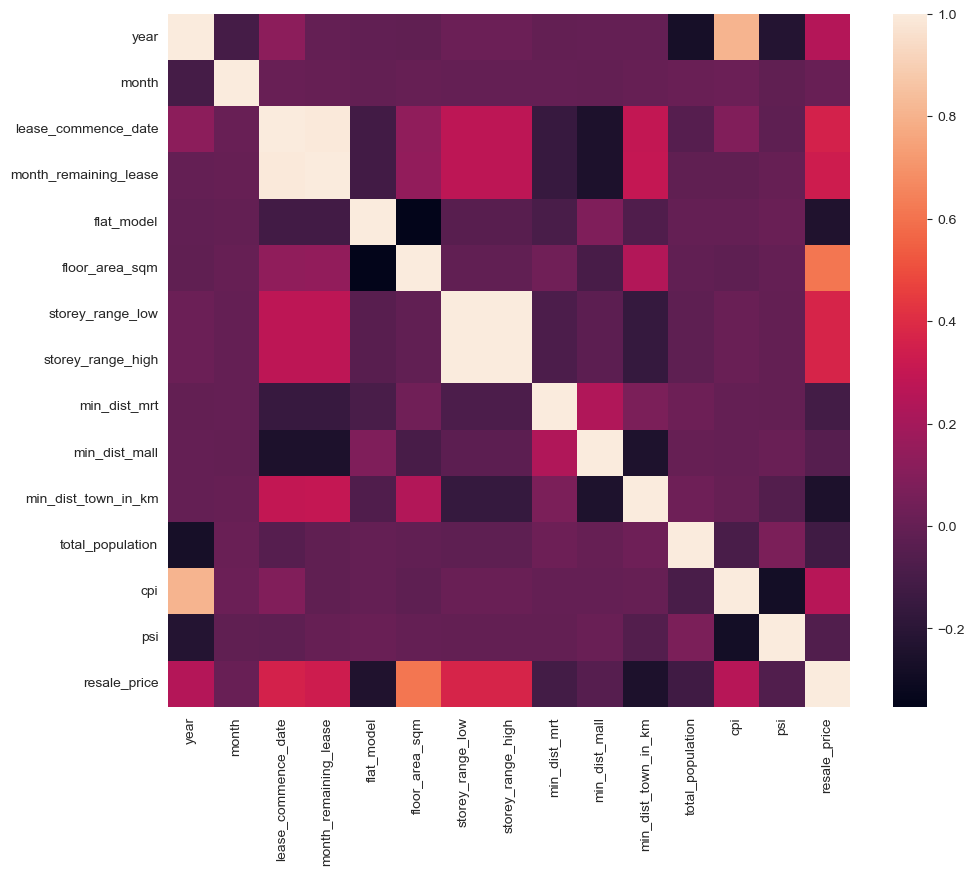

In [8]:
# Compute the correlation matrix
corr = df.corr()
print(corr)

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr())

### Analyzing Categorical Column: town

/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_22078/2773353438.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_22078/2773353438.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)


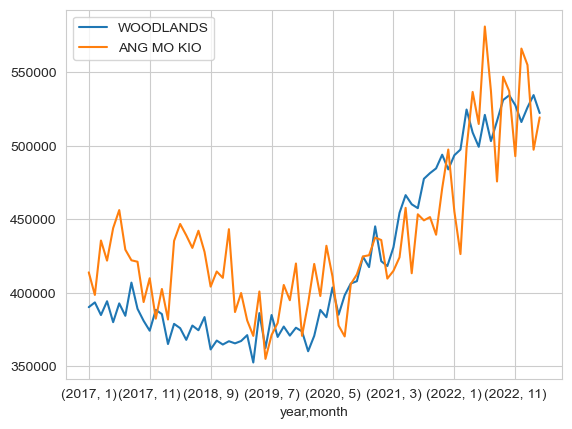

In [9]:
# for each month and year, plot the mean price into line chart with legend
def query_mean_plot_by_town(town):
    df[df['town'] == town].groupby(['year', 'month']).mean()['resale_price'].plot(label=town)
    plt.legend()
    
query_mean_plot_by_town('WOODLANDS')
query_mean_plot_by_town('ANG MO KIO')

<Axes: title={'center': 'Town'}>

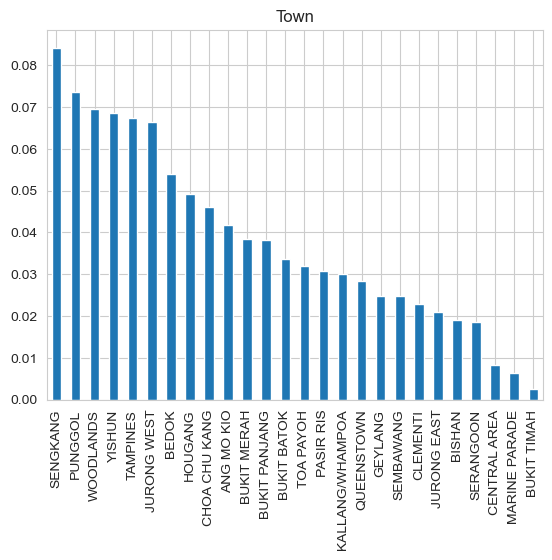

In [10]:
df.town.value_counts(normalize=True).plot(kind='bar', title='Town')

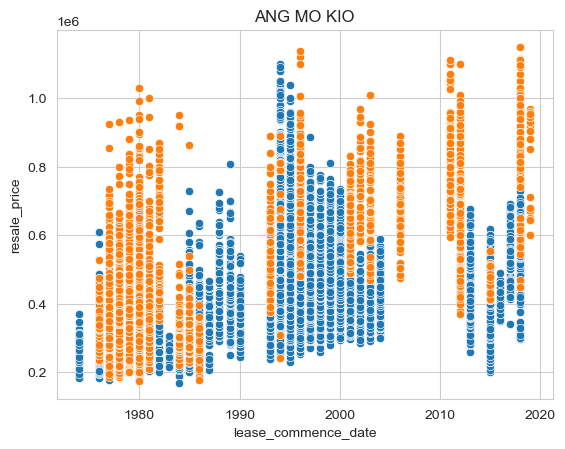

In [11]:
# For each town, plot lease_commence_date against resale price
def plot_date_agst_price(town):
    sns.scatterplot(x='lease_commence_date', y='resale_price', data=df[df['town'] == town])
    plt.title(town)
    

plot_date_agst_price('WOODLANDS')
plot_date_agst_price('ANG MO KIO')

### Analyzing Categorical Column: flat_type

<Axes: title={'center': 'Flat Type'}>

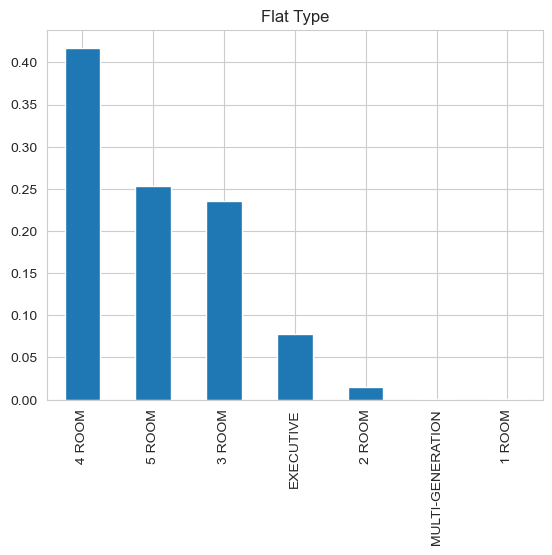

In [12]:
df.flat_type.value_counts(normalize=True).plot(kind='bar', title='Flat Type')

/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_22078/3989628648.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


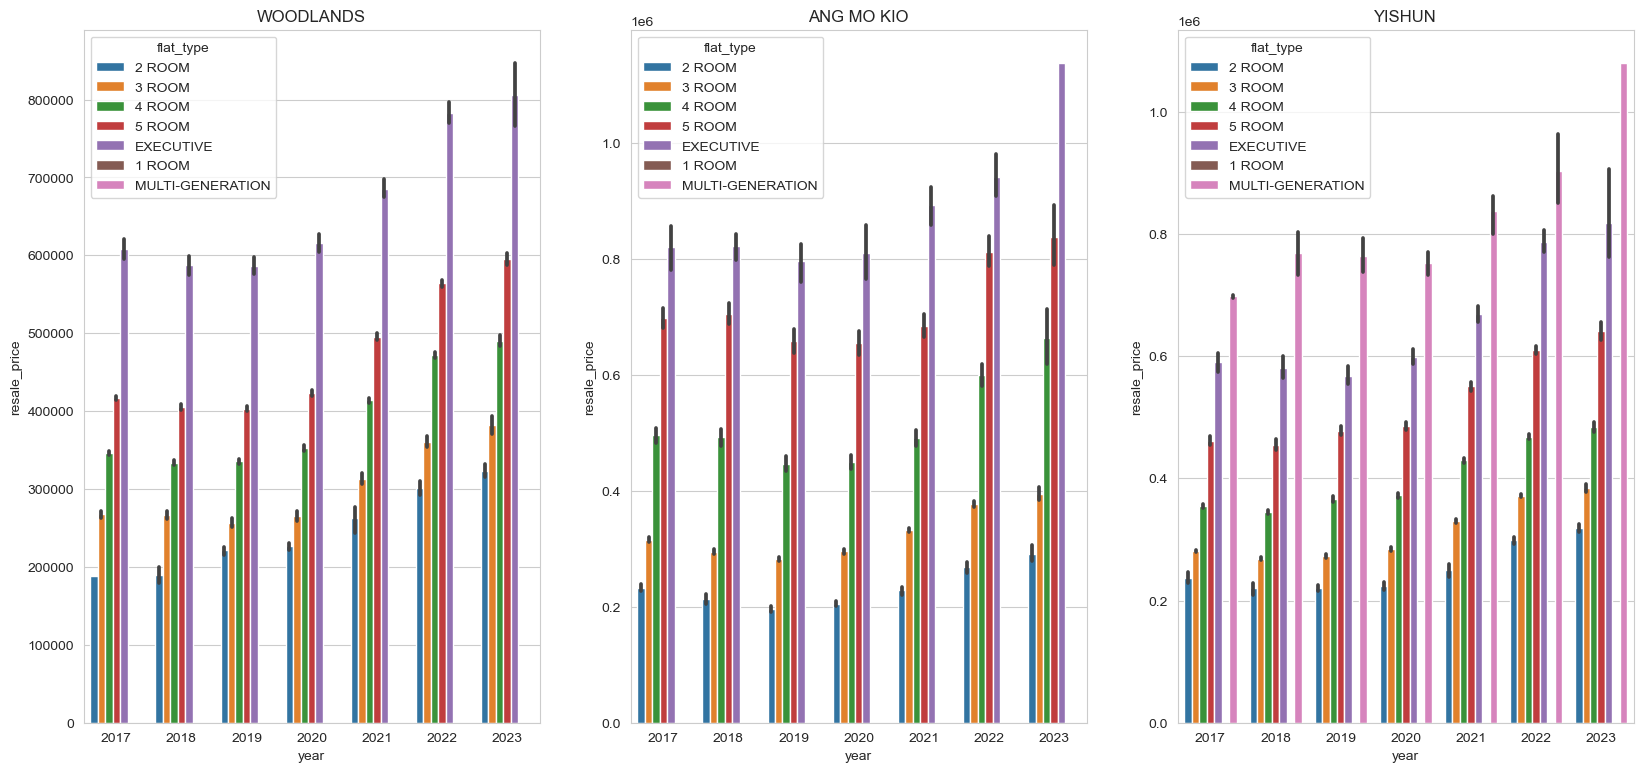

In [13]:
f, ax = plt.subplots(figsize=(20, 9))

def plot_year_against_price(town):
    sns.barplot(data=df[df['town'] == town], x="year", y="resale_price", hue="flat_type", hue_order=df.flat_type.unique())
    plt.title(town)
        
plt.subplot(131)
plot_year_against_price('WOODLANDS')
plt.subplot(132)
plot_year_against_price('ANG MO KIO')
plt.subplot(133)
plot_year_against_price('YISHUN')
    

### Line Plots of Continuous Variables

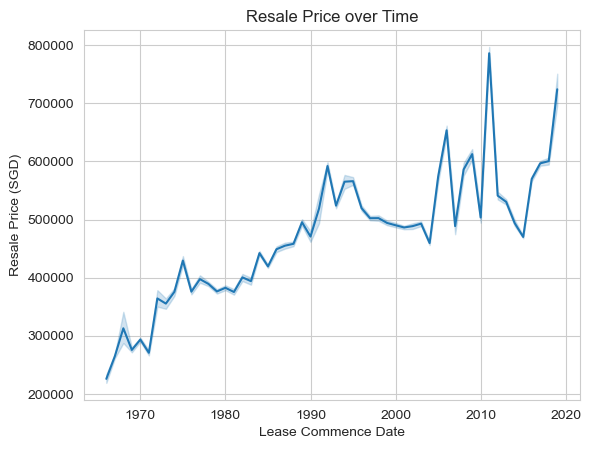

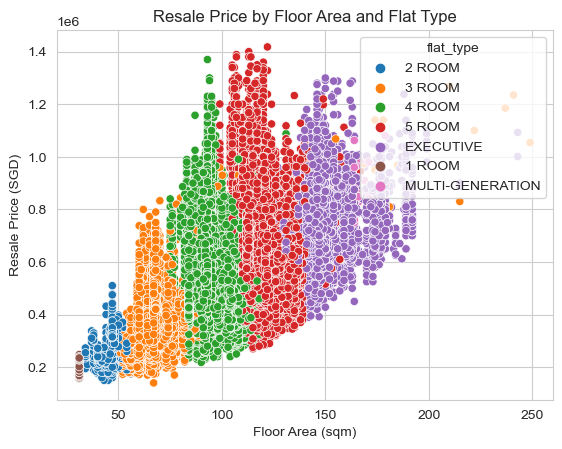

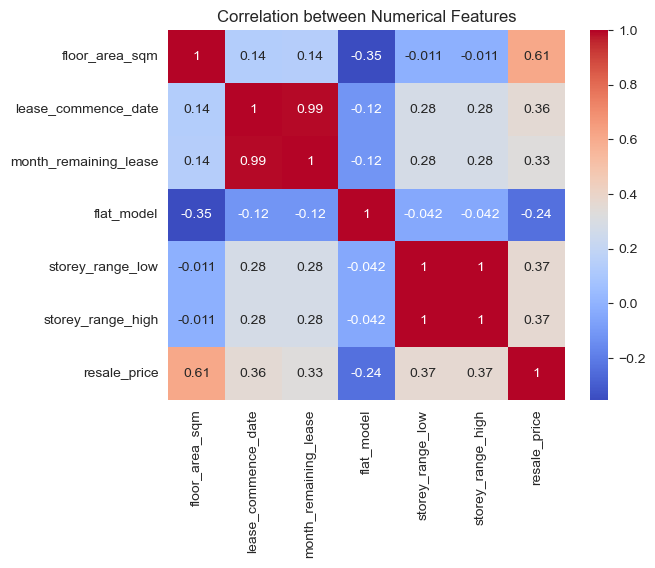

In [14]:
# line plot of lease commence date and resale price
sns.lineplot(x='lease_commence_date', y='resale_price', data=df)
plt.title('Resale Price over Time')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD)')
plt.show()

# scatter plot of remaining lease and resale price
#sns.scatterplot(x='month_remaining_lease', y='resale_price', hue='flat_type', data=df)
#plt.title('Resale Price vs. Remaining Lease')
#plt.xlabel('Remaining Lease (years)')
#plt.ylabel('Resale Price (SGD)')
#plt.show()

# scatter plot of floor area vs. resale price, colored by flat type
sns.scatterplot(x='floor_area_sqm', y='resale_price', hue='flat_type', data=df)
plt.title('Resale Price by Floor Area and Flat Type')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.show()

# heatmap of correlation between numerical features
corr = df[['floor_area_sqm', 'lease_commence_date', 'month_remaining_lease', 'flat_model', 'storey_range_low', 'storey_range_high', 'resale_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()

<h1>Algorithm</h1>

## Regressors Used

1. Decision Tree Regressor

- Mimic human decision-making and can therefore be used in a variety of business settings
- Can be used to compare the costs and likely values of decision pathways that a business might take (future outcomes)
- Benefits: Intuitive, Informational, Scaling

Link: https://www.keboola.com/blog/decision-trees-machine-learning

2. Random Forest Regressor

- Supervised learning algorithm (Learns the mappings between inputs and outputs) and ensemble algorithm (Combine multiple other machine learning algorithms)
- Used to predict continuous values - E.g. Predict future prices/costs, predict future revenue, compare performance
- Benefits: High accuracy, Scalability, Interpretable, Easy to use

Link: https://www.keboola.com/blog/random-forest-regression

3. Gradient Boosting Algorithm

- Used to minimize bias error of the model
- Can be used for predicting not only continuous target variable (as a Regressor) but also categorical target variable (as a Classifier) - In regression problems, the cost function is MSE whereas, in classification problems, the cost function is Log-Loss
- Generally used to decrease the Bias error - The algorithm uses gradient descent to minimize the loss.

Link: https://www.analyticsvidhya.com/blog/2021/04/how-the-gradient-boosting-algorithm-works/; https://blog.paperspace.com/implementing-gradient-boosting-regression-python/



In [15]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [16]:
class PredictionModel:
    def __init__(self, regressor_type):
        self.features = ['floor_area_sqm', 'lease_commence_date', 'month_remaining_lease', 'flat_model', 'storey_range_low', 'storey_range_high', 'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'cpi', 'psi']
        self.y_col = 'resale_price'
        self.regressor_type = regressor_type
    
    def train_model(self, final_df, town, flat_type):
        target_df = final_df[(final_df['town'] == town) & (final_df['flat_type'] == flat_type)]
        y = target_df[self.y_col]
        X = target_df[self.features]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # train using categorical data
        
        return True

    def fit(self):
        if self.regressor_type == "DecisionTreeRegressor":
            regressor = DecisionTreeRegressor(random_state=46)
        elif self.regressor_type == "RandomForestRegressor":
            regressor = RandomForestRegressor(n_estimators=100, random_state=48)
        elif self.regressor_type == "GradientBoostingRegressor":
            regressor = GradientBoostingRegressor()

        return regressor.fit(self.X_train, self.y_train)
    
    def predict(self, regressor):
        return regressor.predict(self.X_test)

    def evaluate(self, y_pred):
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
        print("Mean Squared Error: {:.4f}".format(rmse))
        r2 = r2_score(self.y_test, y_pred)
        print("R2 score: {}".format(r2))
        
        plt.figure(figsize=(7,4))
        plt.scatter(self.y_test, y_pred, c='crimson')
        plt.yscale('log')
        plt.xscale('log')

        p1 = max(max(y_pred), max(self.y_test))
        p2 = min(min(y_pred), min(self.y_test))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show()

    
    def plot_importance(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        importances = pd.Series(data=regressor.feature_importances_, index=self.X_train.columns)
        importances_sorted = importances.sort_values()
        importances_sorted.plot(kind='barh', color='lightgreen')
        plt.title('Features Importances')
        plt.show()
    
    
    def plot_permutation(self, regressor):
        fig, ax = plt.subplots(figsize=(7, 4))
        result = permutation_importance(regressor, self.X_test, self.y_test, n_repeats=10, random_state=42, n_jobs=2)
        sorted_idx = result.importances_mean.argsort()
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(self.features)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        plt.show()

In [17]:
town = 'WOODLANDS'
flat_type = '4 ROOM'

fig = plt.figure(figsize=(6, 6))
# Decision Tree Regressor
print(town, "-", flat_type)
decision_tree_model = PredictionModel('DecisionTreeRegressor')
decision_tree_model.train_model(df.copy(), town, flat_type)
decision_tree_regressor = decision_tree_model.fit()
y_pred = decision_tree_model.predict(decision_tree_regressor)
decision_tree_model.evaluate(y_pred)
decision_tree_model.plot_importance(decision_tree_regressor)
decision_tree_model.plot_permutation(decision_tree_regressor)

WOODLANDS - 4 ROOM


ValueError: Input X contains NaN.
DecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Figure size 600x600 with 0 Axes>

WOODLANDS - 4 ROOM
Mean Squared Error: 22240.0680
R2 score: 0.9093329004963958


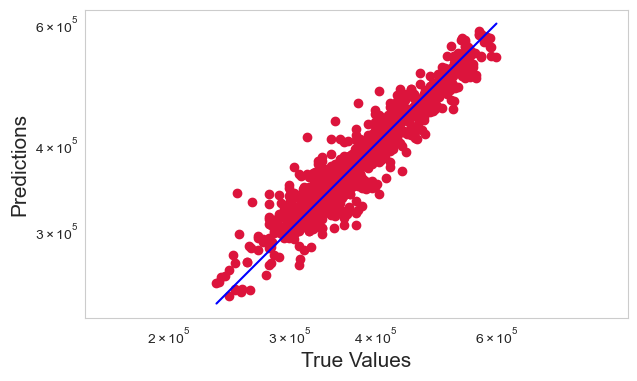

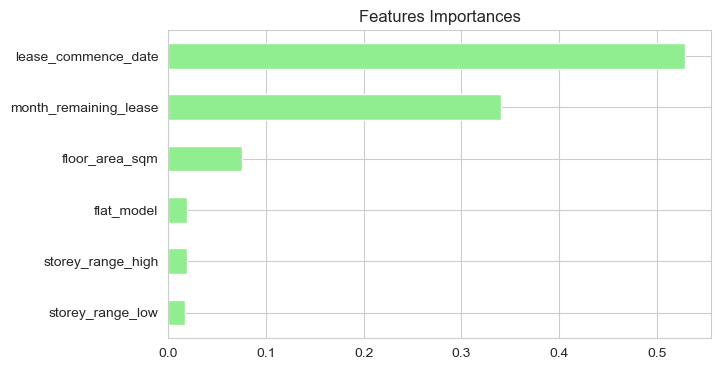

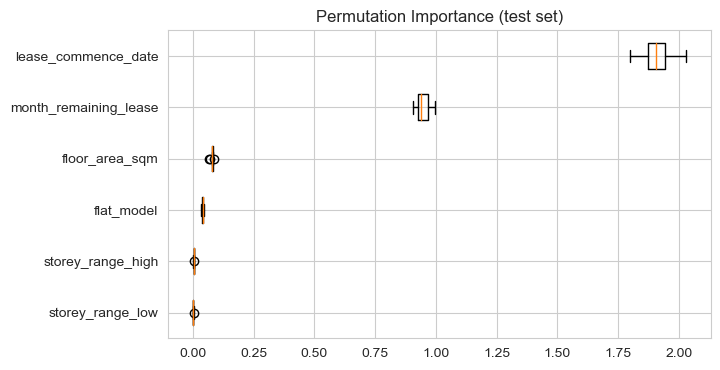

In [ ]:
# Random Forest Regressor
print(town, "-", flat_type)
random_forest_model = PredictionModel('RandomForestRegressor')
random_forest_model.train_model(df.copy(), town, flat_type)
random_forest_regressor = random_forest_model.fit()
y_pred = random_forest_model.predict(random_forest_regressor)
random_forest_model.evaluate(y_pred)
random_forest_model.plot_importance(random_forest_regressor)
random_forest_model.plot_permutation(random_forest_regressor)

WOODLANDS - 4 ROOM
Mean Squared Error: 27356.1823
R2 score: 0.8628207326395988


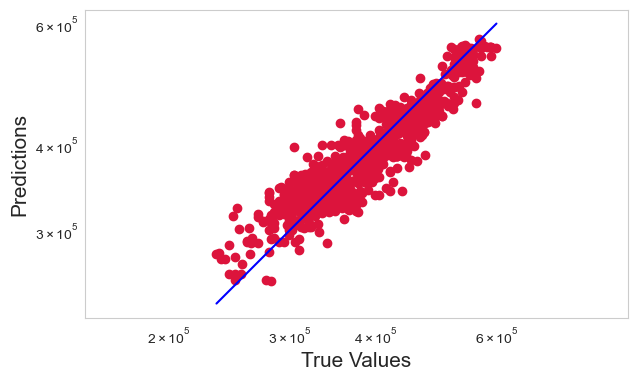

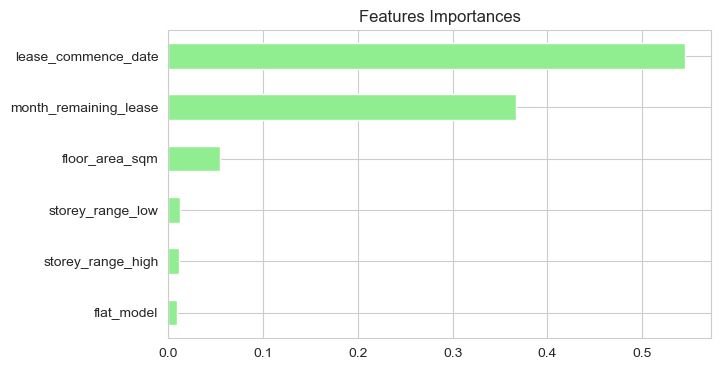

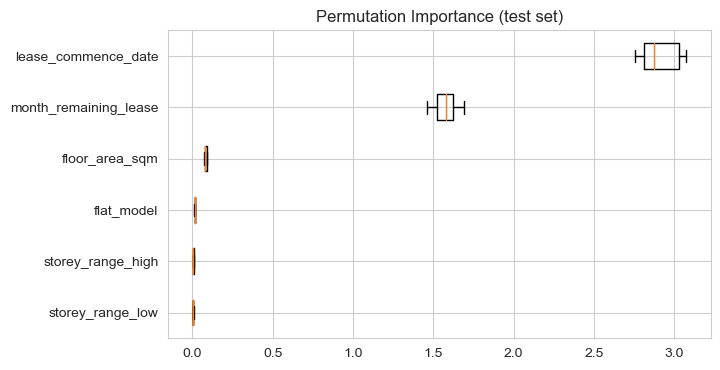

In [ ]:
# Gradient Boosting Regressor
print(town, "-", flat_type)
gb_model = PredictionModel('GradientBoostingRegressor')
gb_model.train_model(df.copy(), town, flat_type)
gb_regressor = gb_model.fit()
y_pred = gb_model.predict(gb_regressor)
gb_model.evaluate(y_pred)
gb_model.plot_importance(gb_regressor)
gb_model.plot_permutation(gb_regressor)

## Possible Improvements to Be Made

1. Consider additional data columns that may possibly affect prices of flats
- Distance to nearest MRT station
- Distance to recreational buildings (e.g. Shopping malls, Community Centers, Parks)
- PSI of location
- Population in Singapore
- Cost of landed properties
- Cost of condominiums
- Cost of living in Singapore

1. Consider removal of outliers
- Removal of data affected by unexpected world affairs such as COVID